# Classmate Opinion Analysis with Text Analysis
### With ckip_transformers 

## Import Package

In [89]:
# package for basic analysis
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from operator import itemgetter

# package for text mining
from ckip_transformers.nlp import CkipWordSegmenter, CkipPosTagger, CkipNerChunker
from nltk import bigrams

# for wordcloud
from wordcloud import WordCloud, ImageColorGenerator

# for RNN model
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers

# for t-SNE model
from sklearn.manifold import TSNE

# for network graph
import networkx as nx
from community import community_louvain

## Load the data

In [3]:
df = pd.read_csv('/Users/wen/Desktop/ClassmateOpinionAnalysis/1102_class_profiles.tsv', sep='\t')
df.head()

,ID,請問你是否支持烏克蘭去納粹化？,請問你是否支持俄羅斯侵略烏克蘭？,2022/3/3 全台灣大停電，你認為原因為何？,請問你最關注以下哪個議題？,請問你認為，烏國／俄國哪邊會贏得戰爭？贏家會獲得什麼？,請問你認為本國應如何改善硬體、軟體、或政策，使電力供應穩定？,請問你需要回家掃墓嗎？若需要，會掃哪些人的墓？如何進行？,請問你是否支持本國婚姻平權政策？能否簡述理由？,請問你疫苗完成注射幾劑？各選了哪些廠牌？,近來俄烏之戰的發展，最令你印象深刻的，是哪則新聞？,請問你晚上是否曾接到拜票來電（錄音）？你通常如何回應？,請問你認為謠言的組成為何？如何查證較有效？,請問你支持本國籍人士滿 18 歲即擁投票權嗎？,請問你有屯快篩試劑嗎？,你認同打疫苗、弊大於利的看法嗎？？,請問，你支持蔣家後代從政嗎？為什麼？,請問你認同何美鄕研究員的說法嗎（台灣去年超額死亡率為負）？為什麼？
0,P1,5. 非常反對,5.非常反對,4.確實是跳電疏失，但輿論風向不該帶往“沒有缺電”，應該起初就好好解釋為何停電，停電跟跳電確...,1. 烏俄之戰，因為影響總體經濟及財務金融層面太多，然後股票前陣子因為打仗輸很慘。,我認為兩邊都有一定程度上的損失，但以國際局勢的角度來看現在俄羅斯是完全壞人的角色，雖然掌握歐...,給工程師高一點的薪水，做好一點的系統，不要再讓唐鳳這種天才外包ＰＭ成為主流掌握大部分國家系統...,還真的不需要，因為去年跟今年疫情靈骨塔在連假都沒有開放，家人已經提前去掃墓,支持，因爲選擇婚配對象應是每人與生俱來的全力，我們不該用性別認同的理由或框架綁架他人的權利，...,兩劑， 皆為AZ,俄羅斯士兵強暴烏克蘭婦女，先姦後殺，令人髪指,否,謠言的組成我認為分為目的性以及娛樂性，現在因為逼近選舉，大多的謠言都帶有目的性，以及台灣的選...,我不支持，因為不知道為什麼現在2000年後出生的小孩好像跟他講什麼都會相信，沒什麼自主判斷能...,沒有，我不是恐慌仔,否，不打大家都會完蛋,如果是自身能力很好或者是透過自己的努力，那可以，如果只是血統buff跟黨機器的運作這樣不行，...,我不認同，因為我覺得應該要針對COVID-19這個事件本身來算這個事件的死亡率，拿過去的平均...
1,P2,1,2,2,6. 歐洲核子研究中心的大型量子對撞機計劃重新啟動,烏克蘭，贏得美國的後續支持和世界輿論,通過向日本引進技術,不掃,支持，現代婚姻關係更實用於法律意義而非社會倫理,兩劑，大興,澤連斯基的摳圖背景,"no , usually hang up directly",無法查證，所有的真實都是主觀需求而非客觀存在,否，他們還不是納稅人，也沒有經濟壓力，不承擔社會責任，可以極左而不承擔後果,NaN,打疫苗利大於弊,不反對，不了解蔣家後，對他不反對也不支持。,反對，身邊有很多人都留下了不可逆轉的嚴重新冠後遺症
2,P3,3. 沒意見,5.非常反對,2.缺電,4.HBL,俄國 土地及資源,蓋核電廠,不需要,不支持也不反對，因為那是別人的自由，我不想干涉,三劑，前兩劑Az，第三劑莫德納,沒有特別印象深刻的，很少在關注,沒有，沒在接電話,一群笨蛋加一個聰明人， 當那個聰明人,我覺得都可以，每個人對於政治有獨立思考的年齡都不同，所以抓一個大概沒問題,沒有,不認同，因為我現在就是三劑完確診，很不舒服，如果沒打三劑我覺得我會不舒服到死,我不表態，因為我根本沒在關注,認同，畢竟我確診康復，對她講的我認為很有道理
3,P4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,P5,3.沒意見,4.有點反對,4.要有核電比較好,2.大S結婚,"俄羅斯會贏,贏了可以在烏克蘭建立魁儡政權",把核四蓋回來,不掃墓,"支持,婚姻平權我覺得是對人權的一種保障",2劑 bnt bnt,普丁被取消黑帶證書,我都不會理他,有人放出假消息 多打聽,支持,沒有屯,"我認為疫苗利大於弊,但是我認為沒有打到三劑的必要","支持,我認為從不從政跟血統無關,純粹看趴們的意願","不認同,我認為沒確診還是最好的"


In [4]:
# check data shape and all col
display(df.shape, df.columns)

(39, 18)

Index(['ID', '請問你是否支持烏克蘭去納粹化？', '請問你是否支持俄羅斯侵略烏克蘭？ ',
       '2022/3/3 全台灣大停電，你認為原因為何？', '請問你最關注以下哪個議題？',
       '請問你認為，烏國／俄國哪邊會贏得戰爭？贏家會獲得什麼？', '請問你認為本國應如何改善硬體、軟體、或政策，使電力供應穩定？',
       '請問你需要回家掃墓嗎？若需要，會掃哪些人的墓？如何進行？', '請問你是否支持本國婚姻平權政策？能否簡述理由？',
       '請問你疫苗完成注射幾劑？各選了哪些廠牌？', '近來俄烏之戰的發展，最令你印象深刻的，是哪則新聞？ ',
       '請問你晚上是否曾接到拜票來電（錄音）？你通常如何回應？', '請問你認為謠言的組成為何？如何查證較有效？',
       '請問你支持本國籍人士滿 18 歲即擁投票權嗎？', '請問你有屯快篩試劑嗎？', '你認同打疫苗、弊大於利的看法嗎？？',
       '請問，你支持蔣家後代從政嗎？為什麼？', '請問你認同何美鄕研究員的說法嗎（台灣去年超額死亡率為負）？為什麼？'],
      dtype='object')

## Data Cleaning

In [5]:
# split myself opinion from the data
myself = df.loc[df['ID'] == 'P34']
myself

,ID,請問你是否支持烏克蘭去納粹化？,請問你是否支持俄羅斯侵略烏克蘭？,2022/3/3 全台灣大停電，你認為原因為何？,請問你最關注以下哪個議題？,請問你認為，烏國／俄國哪邊會贏得戰爭？贏家會獲得什麼？,請問你認為本國應如何改善硬體、軟體、或政策，使電力供應穩定？,請問你需要回家掃墓嗎？若需要，會掃哪些人的墓？如何進行？,請問你是否支持本國婚姻平權政策？能否簡述理由？,請問你疫苗完成注射幾劑？各選了哪些廠牌？,近來俄烏之戰的發展，最令你印象深刻的，是哪則新聞？,請問你晚上是否曾接到拜票來電（錄音）？你通常如何回應？,請問你認為謠言的組成為何？如何查證較有效？,請問你支持本國籍人士滿 18 歲即擁投票權嗎？,請問你有屯快篩試劑嗎？,你認同打疫苗、弊大於利的看法嗎？？,請問，你支持蔣家後代從政嗎？為什麼？,請問你認同何美鄕研究員的說法嗎（台灣去年超額死亡率為負）？為什麼？
33,P34,05.非常反對（在這次俄羅斯出兵烏克蘭的理由為指控烏克蘭對境內烏東傾蘇人民進行種族清洗、迫害...,05.非常反對,03.跳電（在核電的議題上我認為我支持核電但反對核四啟用(因核四的興建過程的確存在許多瑕疵)...,我比較在乎烏俄戰爭，因為我認為這樣的新聞更有延續性，並且就目前為止戰況持續有在發展，並未進入...,我認為最後烏克蘭會獲勝，由《集體安全理論》的觀點來看，強國需要中小型的成員國以壯大其聲勢，而...,我認為應該持續推動綠能發展，減少火力發電的使用。,我們家沒有在掃墓的習慣，所以不會掃墓。,我認為目前已經立法的婚姻政策僅限縮於「是否可以結婚？」的框架之下，確實已經是一個很大的進步，...,目前完成注射3劑，前兩劑為AZ，最後一劑是莫德納,我印象最深的新聞是烏克蘭總理將北約國家分為四類，認為北約各國其實在烏俄戰爭中有著不同的目的。,因為住的地方沒有市內電話所以不會接到，但很希望有機會可以接到拜票電話。,我認為謠言的組成來自於假消息，並且經由媒體受聽人未經查證又再轉傳，導致演變成似是而非的資訊。...,我支持滿18歲的本國籍人士需要擁有投票權。依我國「刑法」規定第18條規定，18歲以上需負完全...,我沒有購買快篩試劑因為我覺得醫療量能應該留給其他更需要的人，例如工作有規定必須有近期快篩結果...,我認同打疫苗利大於弊的想法，因為整體來看，國外已經在嘗試與病毒共存，那勢必要能夠達到全體免疫...,我是不支持蔣家後代從政的，就轉型正義的角度來說，台灣應該要是去蔣的，然而事實是中正紀念堂還在...,我覺得我是同意的，因為我們目前的目標是要與病毒共存，因此應該要達到全體免疫的脈絡之下，絕大多...


In [6]:
# split authority to as data 
# authority = df.loc[:, ['ID', '請問，你支持蔣家後代從政嗎？為什麼？']]
# authority.head()
# save authority as csv
# authority.to_csv('/Users/wen/Desktop/authority.csv')

## Reload the Data

In [7]:
authority = pd.read_csv('/Users/wen/Desktop/ClassmateOpinionAnalysis/authority.csv')
authority.head()

,Unnamed: 0,ID,請問，你支持蔣家後代從政嗎？為什麼？,是否支持,label
0,0,P1,如果是自身能力很好或者是透過自己的努力，那可以，如果只是血統buff跟黨機器的運作這樣不行，...,-1.0,0.0
1,1,P2,不反對，不了解蔣家後，對他不反對也不支持。,0.0,1.0
2,2,P3,我不表態，因為我根本沒在關注,0.0,1.0
3,3,P4,NaN,NaN,NaN
4,4,P5,"支持,我認為從不從政跟血統無關,純粹看趴們的意願",1.0,1.0


In [8]:
authority.dropna(inplace=True)
authority = authority.drop(['Unnamed: 0'], axis=1)
authority = authority.reset_index()

In [9]:
# recode 
authority.loc[authority['是否支持'] == 1, 'Election'] = 'Yes'
authority.loc[authority['是否支持'] == -1, 'Election'] = 'No'
authority.loc[authority['是否支持'] == 0, 'Election'] = 'No Comments'

## NLP Pre-processing
With Bert

In [10]:
# Initialize drivers
ws_driver = CkipWordSegmenter(level=3)
pos_driver = CkipPosTagger(level=3)
ner_driver = CkipNerChunker(level=3)

### Tokenize

In [11]:
sentence_list = []

for i in authority['請問，你支持蔣家後代從政嗎？為什麼？'] :
    sentence_list.append(str(i))

In [12]:
ws = ws_driver(sentence_list)

Inference: 100%|██████████| 1/1 [00:14<00:00, 14.07s/it]


In [13]:
# add token to authority
authority['Token'] = np.array(ws)

/var/folders/dn/wbyhv8k14697mm1zy19w1jh40000gn/T/ipykernel_2627/2863219214.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  authority['Token'] = np.array(ws)


### Part of speech tagging

In [14]:
pos = pos_driver(ws)

Inference: 100%|██████████| 1/1 [00:18<00:00, 18.35s/it]


In [15]:
# add POS to authority
authority['POS'] = np.array(pos)

/var/folders/dn/wbyhv8k14697mm1zy19w1jh40000gn/T/ipykernel_2627/4254319422.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  authority['POS'] = np.array(pos)


### Named Entity Recognition

In [16]:
ner = ner_driver(sentence_list)

Inference: 100%|██████████| 1/1 [00:13<00:00, 13.41s/it]


In [17]:
# add NER to authority
authority['NER'] = np.array(ner)

/var/folders/dn/wbyhv8k14697mm1zy19w1jh40000gn/T/ipykernel_2627/1144693889.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  authority['NER'] = np.array(ner)


## Data Visualization

### Bar Chart

In [18]:
authority['Election'].value_counts()

Yes            18
No Comments    14
No              3
Name: Election, dtype: int64

In [19]:
fig1 = px.pie(authority, 
            width = 700,
            values = authority['Election'].value_counts(), hole=0.4,
            names = ['Yes', 'No Comments', 'No'],
            )
fig1.update_layout(title='是否支持蔣家後代從政', font_size=16, title_x=0.43)           
fig1.show()

### NER Result Visulization

#### Count NER

In [20]:
person = 0
org = 0
gpe = 0
fac = 0
cardinal = 0
norp = 0

for i in authority['NER']:
    for n in i:
        if n[1] == 'PERSON':
            person = person + 1
        elif n[1] == 'ORG':
            org = org + 1
        elif n[1] == 'GPE':
            gpe = gpe + 1
        elif n[1] == 'FAC':
            fac = fac + 1
        elif n[1] == 'NORP':
            norp = norp + 1
        elif n[1] == 'CARDINAL':
            cardinal = cardinal + 1
        else :
            pass

In [21]:
# Plot the bar chart
Type = ['ORG','CARDINAL','FAC','PERSON','GPE', 'NORP']            
Counts = [org, cardinal, fac, person, gpe, norp] 
fig2 = px.bar(height=500, width=500,
              x = Type, y = Counts,
              text = Counts,
              title="NER result")
fig2.update_layout(xaxis_title_text='NER Type', yaxis_title_text='Counts',bargap=0.2,bargroupgap=0.1)
fig2.show()

### Wordcloud

#### Remove common word with stopwords

In [22]:
# Set up stop word
stop_words = open('/Users/wen/Desktop/ClassmateOpinionAnalysis/stopwords.txt', encoding='utf-8').readlines()

stopwords_list = [] 
for i in range(len(stop_words)):
    stop_words[i] = stop_words[i].replace('\n','')
    stopwords_list.append(stop_words[i])

In [23]:
# remove 
clean_words = []
for i in ws:
    for n in i:
        if n not in stopwords_list:
            clean_words.append(n)

#### Count keyword 

In [24]:
# set a dic
keyword_dict = {}

# 每個 token 都比對一遍；如果已存在則加次數
for token in clean_words:
    if token in keyword_dict:
        keyword_dict[token] = keyword_dict[token] + 1
    else:
        keyword_dict[token] = 1

In [25]:
keyworddf = pd.DataFrame(list(keyword_dict.items()),columns=['Word', 'Value'])
keyworddf = keyworddf.sort_values('Value', ascending=False)
keyworddf.head(10)

,Word,Value
0,能力,6
14,民主,6
13,自由,5
42,權利,3
26,背景,3
15,正當,3
20,正義,3
50,姓,3
2,血統,3
43,祖先,2


#### Plot Wordcloud

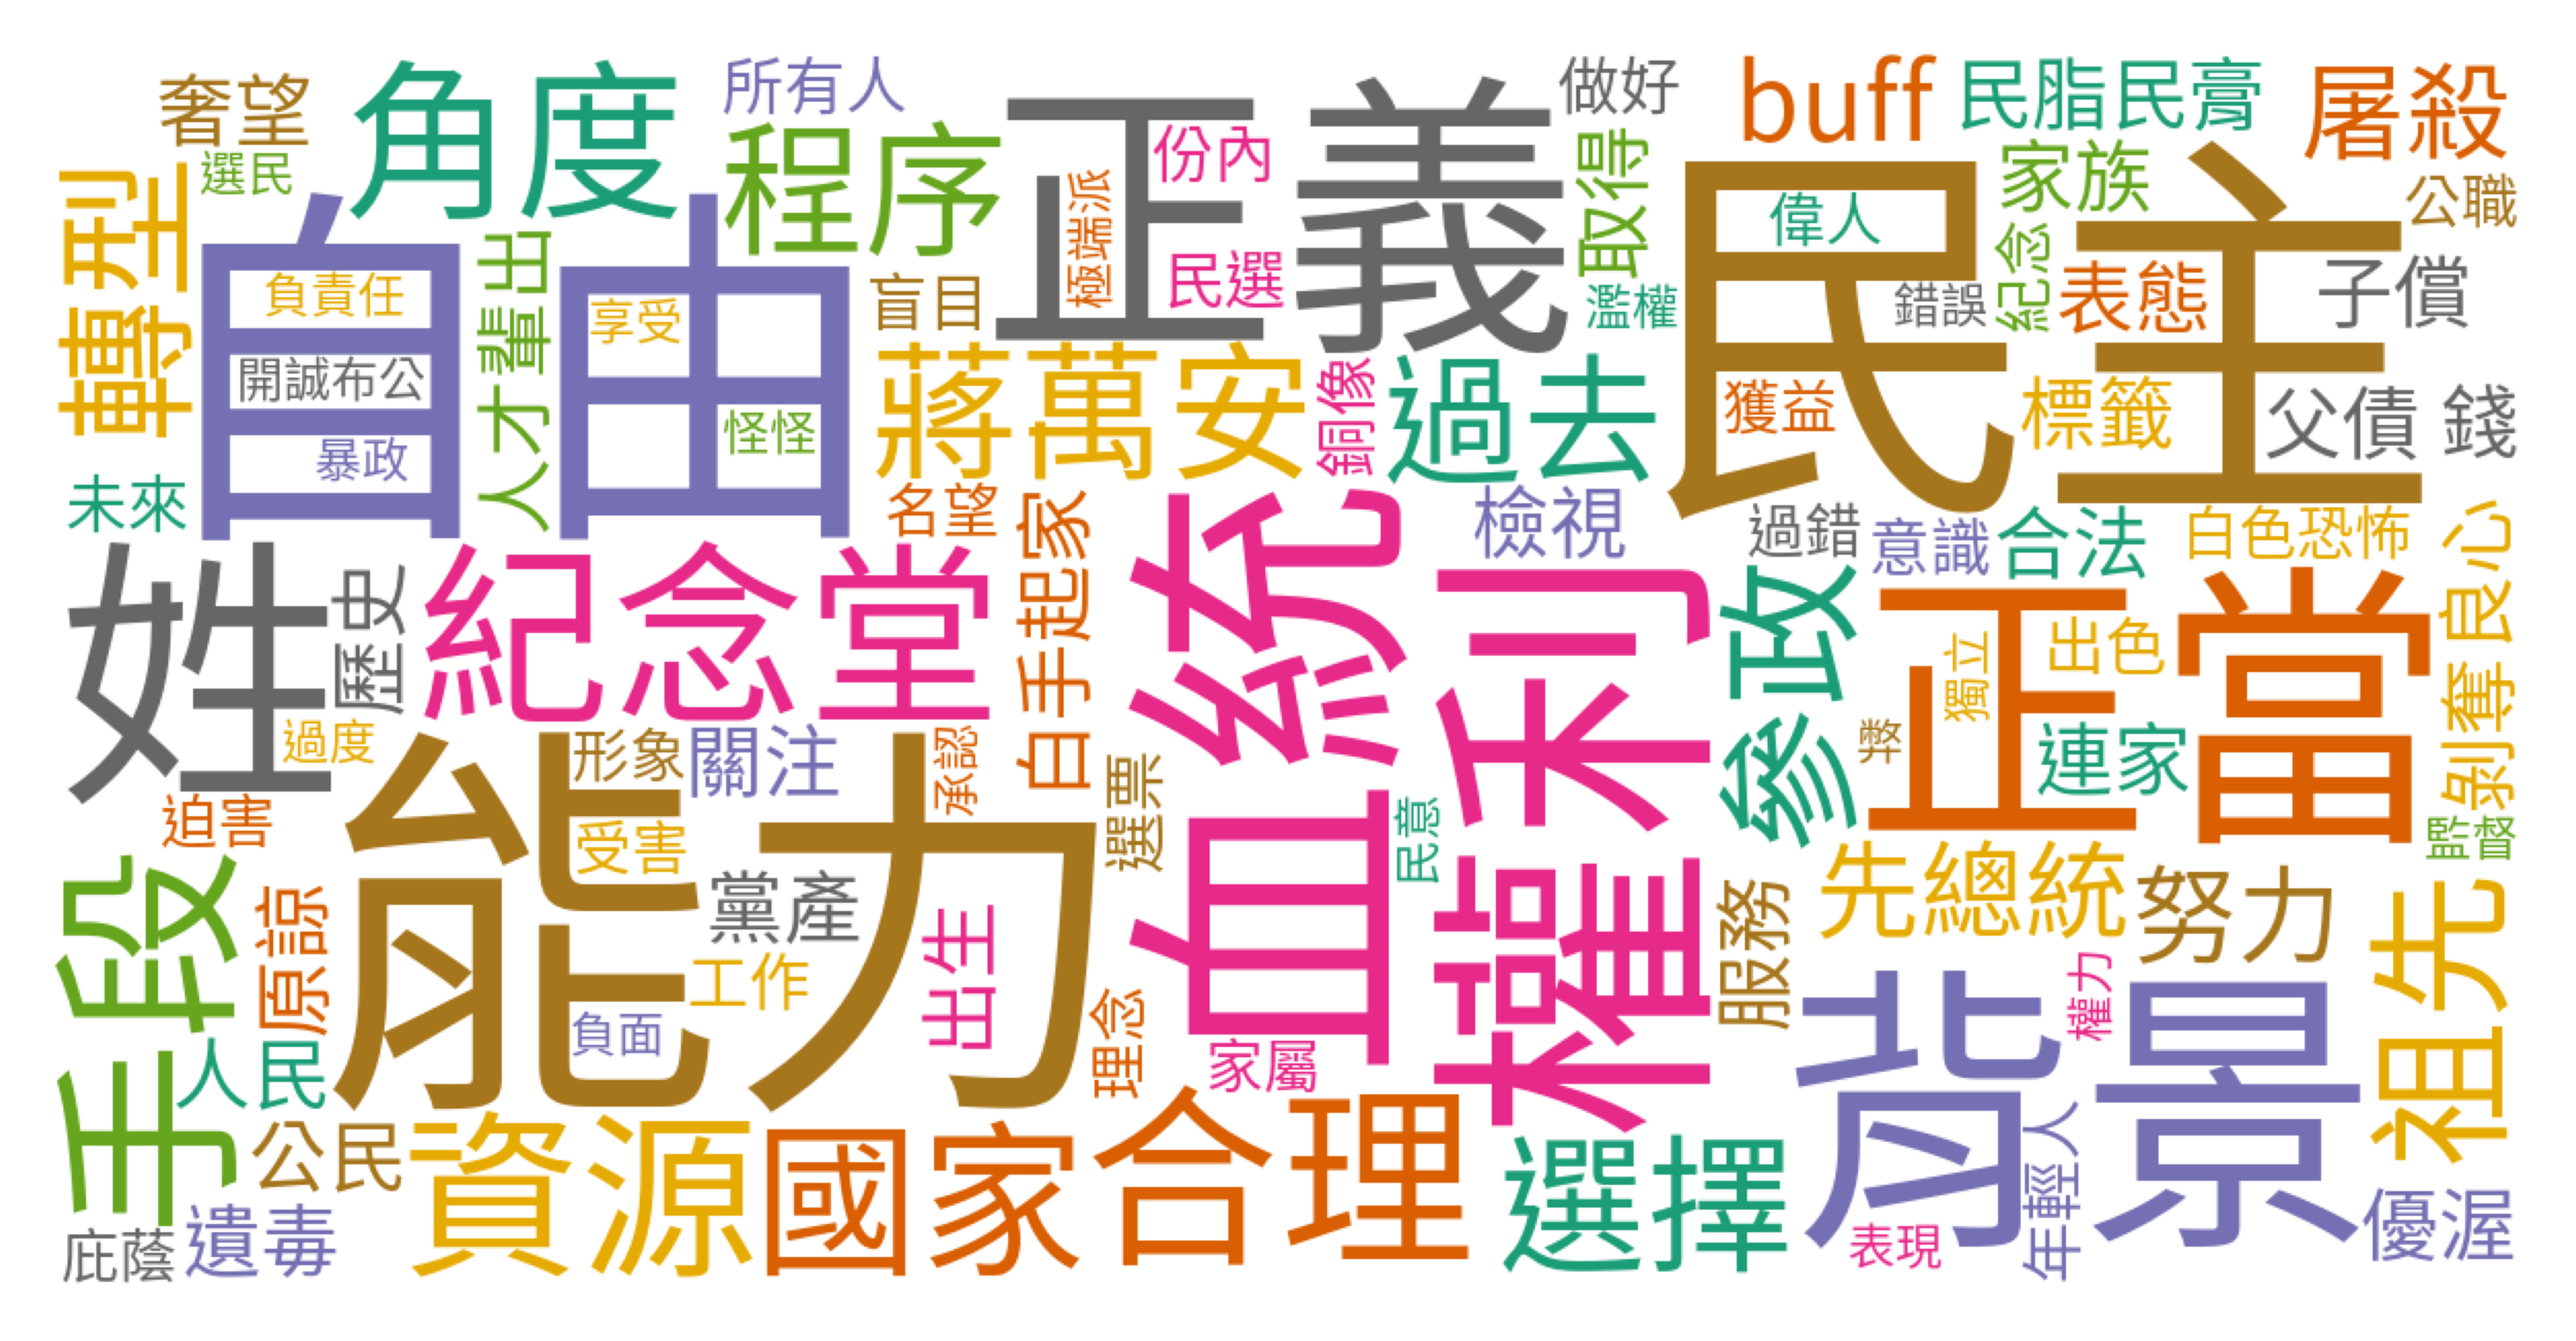

In [26]:
text = " ".join(word for word in clean_words)
font_path = '/Users/wen/Desktop/Data Science/Python/NLP/WordCloud/SourceHanSansTW-Regular.otf'
wordcloud = WordCloud(width=1200, height=600, max_font_size=200, max_words=200, background_color="white", font_path=font_path, colormap="Dark2").generate(text)
plt.figure(dpi=600)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()    

## NLP Model 

### Training Model

In [27]:
authority.head()

,index,ID,請問，你支持蔣家後代從政嗎？為什麼？,是否支持,label,Election,Token,POS,NER
0,0,P1,如果是自身能力很好或者是透過自己的努力，那可以，如果只是血統buff跟黨機器的運作這樣不行，...,-1.0,0.0,No,"[如果, 是, 自身, 能力, 很, 好, 或者, 是, 透過, 自己, 的, 努力, ，,...","[Cbb, SHI, Nh, Na, Dfa, VH, Caa, SHI, P, Nh, D...","[(蔣, PERSON, (48, 49)), (台灣, GPE, (53, 55)), (..."
1,1,P2,不反對，不了解蔣家後，對他不反對也不支持。,0.0,1.0,No Comments,"[不, 反對, ，, 不, 了解, 蔣家, 後, ，, 對, 他, 不, 反對, 也, 不,...","[D, VE, COMMACATEGORY, D, T, Nb, Ng, COMMACATE...","[(蔣, PERSON, (7, 8))]"
2,2,P3,我不表態，因為我根本沒在關注,0.0,1.0,No Comments,"[我, 不, 表態, ，, 因為, 我, 根本, 沒, 在, 關注]","[Nh, D, VA, COMMACATEGORY, Cbb, Nh, D, D, P, VJ]",[]
3,4,P5,"支持,我認為從不從政跟血統無關,純粹看趴們的意願",1.0,1.0,Yes,"[支持, ,, 我, 認為, 從不, 從政, 跟, 血統, 無關, ,, 純粹, 看, 趴,...","[VC, COMMACATEGORY, Nh, VE, D, VA, P, Na, VH, ...",[]
4,6,P7,他開心就好，參選是每個人的自由,0.0,1.0,No Comments,"[他, 開心, 就, 好, ，, 參選, 是, 每, 個, 人, 的, 自由]","[Nh, VH, D, VH, COMMACATEGORY, VC, SHI, Nes, N...",[]


#### Word to Vector with gensim and Get Embedding
Some gensim function had remove reference github：<br/>

https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4

In [28]:
# import gensim
from gensim.models import Word2Vec

# turn word to vector
vector = Word2Vec(authority.Token, min_count = 1, vector_size = 250, epochs = 10, sg = 1) # after 2021 need to replace size by vector_size

In [29]:
print(vector)

Word2Vec<vocab=395, vector_size=250, alpha=0.025>


In [30]:
vector.wv.key_to_index

{'，': 0,
 '的': 1,
 '我': 2,
 '是': 3,
 '不': 4,
 '。': 5,
 '他': 6,
 '蔣家': 7,
 '支持': 8,
 '從政': 9,
 '有': 10,
 '後代': 11,
 ' ': 12,
 '覺得': 13,
 '因為': 14,
 '沒': 15,
 '都': 16,
 '認為': 17,
 '也': 18,
 '不會': 19,
 '可以': 20,
 '不能': 21,
 '只要': 22,
 '想': 23,
 '人': 24,
 '但': 25,
 '在': 26,
 '台灣': 27,
 '蔣': 28,
 '跟': 29,
 '能力': 30,
 '而': 31,
 '民主': 32,
 '個人': 33,
 '反對': 34,
 '應該': 35,
 '決定': 36,
 '者': 37,
 '特別': 38,
 '政治': 39,
 '意見': 40,
 '就': 41,
 '要': 42,
 '如果': 43,
 '自由': 44,
 '一樣': 45,
 '說': 46,
 '還': 47,
 '過': 48,
 '看': 49,
 '自己': 50,
 '了': 51,
 '參選': 52,
 '個': 53,
 '太': 54,
 '上': 55,
 '什麼': 56,
 '會': 57,
 '這': 58,
 '大家': 59,
 '重點': 60,
 '去': 61,
 '哈': 62,
 '權利': 63,
 '血統': 64,
 '以': 65,
 '可能': 66,
 '沒有': 67,
 '正義': 68,
 '背景': 69,
 '正當': 70,
 '姓': 71,
 '問題': 72,
 '但是': 73,
 '那': 74,
 '能': 75,
 '蔣經國': 76,
 '基本': 77,
 '同意': 78,
 '紀念堂': 79,
 '是否': 80,
 '祖先': 81,
 '對': 82,
 '參政': 83,
 '一': 84,
 ')': 85,
 '中正': 86,
 '、': 87,
 '選擇': 88,
 '想要': 89,
 '蔣萬安': 90,
 '轉型': 91,
 '來': 92,
 '哪': 93,
 '即可': 94,
 '所以':

In [31]:
# get one term vector
# vector.wv.get_vector('蔣家')

In [32]:
# check the embedding shape
(vector.wv.vectors).shape

(395, 250)

#### Word2vector to Embedding

##### Deal with index[0] is '，'

In [33]:
# index 0 means '，' need to deal with it, replace by 1 so there while be 0 in embedding
[1+vector.wv.key_to_index[sen] for sen in authority.Token[0]] 

[44,
 4,
 198,
 31,
 123,
 115,
 119,
 4,
 200,
 51,
 2,
 196,
 1,
 75,
 21,
 1,
 44,
 207,
 65,
 209,
 30,
 204,
 195,
 2,
 194,
 193,
 178,
 1,
 121,
 29,
 180,
 27,
 28,
 125,
 124,
 183,
 184,
 185,
 186,
 187,
 188,
 48,
 190,
 60,
 192,
 8,
 1,
 87,
 80,
 42,
 4,
 8,
 212,
 6]

In [34]:
embedding_matrix = vector.wv.vectors

In [35]:
# check matrix shape
embedding_matrix.shape 

(395, 250)

In [36]:
# 現在 embedding_matrix[0] 代表的是 '，',要讓一開始是0，所以透過 numpy 疊0的方式處理
embedding_matrix = np.vstack((np.array(np.zeros(250)), embedding_matrix))

In [37]:
# recheck matrix shape after vstack 0 
embedding_matrix.shape

(396, 250)

#### Set up train set

##### x_train

In [38]:
x_train = np.zeros([len(authority.Token), 30], dtype = 'float')

In [39]:
x_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [40]:
authority.Token

0     [如果, 是, 自身, 能力, 很, 好, 或者, 是, 透過, 自己, 的, 努力, ，,...
1     [不, 反對, ，, 不, 了解, 蔣家, 後, ，, 對, 他, 不, 反對, 也, 不,...
2                    [我, 不, 表態, ，, 因為, 我, 根本, 沒, 在, 關注]
3     [支持, ,, 我, 認為, 從不, 從政, 跟, 血統, 無關, ,, 純粹, 看, 趴,...
4               [他, 開心, 就, 好, ，, 參選, 是, 每, 個, 人, 的, 自由]
5     [支持, ，, 我, 認為, 如今, 民主, 時代, ，, 任何, 人, 想, 參選, 參選...
6     [父債, 子償, 不, 太, 合理, ，, 但, 我, 覺得, 以, 不, 正義, 的, 家...
7     [支持, ，, 因為, 他, 是, 後代, ，, 但是, 也, 要, 審慎, 檢視, 他, ...
8          [沒, 意見, ，, 蔣家, 後代, 想, 不, 想, 從政, 是, 他, 的, 自由]
9     [我, 認為, 投身, 政治, 的, 條件, 與否, 在於, 他, 的, 個人, 能力, ，...
10    [我, 認為, 人, 不能, 決定, 自己, 的, 出生, 背景, ，, 貧苦, 不能, 決...
11    [同意,  ,  , 有, 聽, 過, 蔣經國, 先生, 說, 過, 後代, 不, 從政, ...
12    [我, 覺得, 要, 看, 是, 誰,  , 蔣家, 後代, 可能, 也, 不, 想, 被,...
13    [不能, 算是, 支持, ，, 因為, 我, 覺得, 臺灣, 的, 人才輩出, ，, 不, ...
14    [如果, 蔣家, 後代, 有, 能力, 解決, 人民, 的, 問題, ，, 我, 會, 支持...
15    [沒有, 特別, 支持, 或, 不, 支持, ，, 因為, 對, 我, 來說, 蔣家, 的,...
16    [我, 覺得, 蔣經國, 先生, 有沒有, 講, 過, 這, 句, 話, 不, 是, 重點,...
17                        [沒, 什麼, 感覺, ，, 大家, 都, 

In [41]:
# put value into x_train array
for i in range(len(authority.Token)):
    for j in range(min(len(authority.Token[i]), 30)):
        x_train[i, j] = 1 + vector.wv.key_to_index[authority.Token[i][j]]

##### y_train

In [42]:
y_train = authority.label

In [43]:
y_train

0     0.0
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
11    1.0
12    1.0
13    1.0
14    1.0
15    1.0
16    1.0
17    1.0
18    1.0
19    1.0
20    1.0
21    0.0
22    1.0
23    1.0
24    1.0
25    1.0
26    1.0
27    1.0
28    1.0
29    0.0
30    1.0
31    1.0
32    1.0
33    1.0
34    1.0
Name: label, dtype: float64

#### Build RNN Model

##### Check tensorflow version

In [44]:
print(tf.__version__)

2.9.0


In [45]:
RNN = keras.Sequential(name = 'RNN')

RNN.add(layers.Embedding(len(vector.wv.key_to_index) + 1, 250))
RNN.add(layers.SimpleRNN(64))
RNN.add(layers.Dense(2, activation = 'softmax'))

# keras.utils.plot_model(RNN, show_shapes = True)
RNN.summary()

2022-06-14 17:49:42.351224: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 250)         99000     
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                20160     
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 119,290
Trainable params: 119,290
Non-trainable params: 0
_________________________________________________________________


##### Set layers

In [46]:
# Do not train layers 0 
RNN.layers[0].set_weights([embedding_matrix])
RNN.layers[0].trainable = False
RNN.summary()

Model: "RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 250)         99000     
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                20160     
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 119,290
Trainable params: 20,290
Non-trainable params: 99,000
_________________________________________________________________


In [47]:
RNN.compile(optimizer = 'Adam',
            loss = keras.losses.sparse_categorical_crossentropy,
            metrics = ['accuracy'])

In [48]:
RNN.fit(x_train, y_train, epochs = 20)

Epoch 1/20
2/2 [==============================] - 1s 9ms/step - loss: 0.6094 - accuracy: 0.8857
Epoch 2/20
2/2 [==============================] - 0s 9ms/step - loss: 0.4114 - accuracy: 0.9143
Epoch 3/20
2/2 [==============================] - 0s 10ms/step - loss: 0.3341 - accuracy: 0.9143
Epoch 4/20
2/2 [==============================] - 0s 9ms/step - loss: 0.3045 - accuracy: 0.9143
Epoch 5/20
2/2 [==============================] - 0s 13ms/step - loss: 0.2882 - accuracy: 0.9143
Epoch 6/20
2/2 [==============================] - 0s 8ms/step - loss: 0.2906 - accuracy: 0.9143
Epoch 7/20
2/2 [==============================] - 0s 9ms/step - loss: 0.3009 - accuracy: 0.9143
Epoch 8/20
2/2 [==============================] - 0s 7ms/step - loss: 0.3145 - accuracy: 0.9143
Epoch 9/20
2/2 [==============================] - 0s 8ms/step - loss: 0.3126 - accuracy: 0.9143
Epoch 10/20
2/2 [==============================] - 0s 7ms/step - loss: 0.3037 - accuracy: 0.9143
Epoch 11/20
2/2 [====================

#### Prediction

In [49]:
predict_x = RNN.predict(x_train) 
classes_x = np.argmax(predict_x,axis=1)

2/2 [==============================] - 0s 6ms/step


In [50]:
authority['Pre_result'] = classes_x

##### Estimate RNN Result

In [51]:
authority['Estimate'] = authority['Pre_result'] - authority['是否支持']

In [52]:
authority.head()

,index,ID,請問，你支持蔣家後代從政嗎？為什麼？,是否支持,label,Election,Token,POS,NER,Pre_result,Estimate
0,0,P1,如果是自身能力很好或者是透過自己的努力，那可以，如果只是血統buff跟黨機器的運作這樣不行，...,-1.0,0.0,No,"[如果, 是, 自身, 能力, 很, 好, 或者, 是, 透過, 自己, 的, 努力, ，,...","[Cbb, SHI, Nh, Na, Dfa, VH, Caa, SHI, P, Nh, D...","[(蔣, PERSON, (48, 49)), (台灣, GPE, (53, 55)), (...",1,2.0
1,1,P2,不反對，不了解蔣家後，對他不反對也不支持。,0.0,1.0,No Comments,"[不, 反對, ，, 不, 了解, 蔣家, 後, ，, 對, 他, 不, 反對, 也, 不,...","[D, VE, COMMACATEGORY, D, T, Nb, Ng, COMMACATE...","[(蔣, PERSON, (7, 8))]",1,1.0
2,2,P3,我不表態，因為我根本沒在關注,0.0,1.0,No Comments,"[我, 不, 表態, ，, 因為, 我, 根本, 沒, 在, 關注]","[Nh, D, VA, COMMACATEGORY, Cbb, Nh, D, D, P, VJ]",[],1,1.0
3,4,P5,"支持,我認為從不從政跟血統無關,純粹看趴們的意願",1.0,1.0,Yes,"[支持, ,, 我, 認為, 從不, 從政, 跟, 血統, 無關, ,, 純粹, 看, 趴,...","[VC, COMMACATEGORY, Nh, VE, D, VA, P, Na, VH, ...",[],1,0.0
4,6,P7,他開心就好，參選是每個人的自由,0.0,1.0,No Comments,"[他, 開心, 就, 好, ，, 參選, 是, 每, 個, 人, 的, 自由]","[Nh, VH, D, VH, COMMACATEGORY, VC, SHI, Nes, N...",[],1,1.0


In [53]:
fig3 = px.pie(authority, 
            width = 700,
            values = authority['Estimate'].value_counts(), hole=0.4,
            names = ['Yes', 'No Comments', 'No']
            )
fig3.update_layout(title='RNN 模型結果評估', font_size=16, title_x=0.43)           
fig3.show()

In [54]:
authority['Estimate'].value_counts()

0.0    18
1.0    14
2.0     3
Name: Estimate, dtype: int64

### Visualizing Word Embeddings using t-SNE

In [55]:
authority.head()

,index,ID,請問，你支持蔣家後代從政嗎？為什麼？,是否支持,label,Election,Token,POS,NER,Pre_result,Estimate
0,0,P1,如果是自身能力很好或者是透過自己的努力，那可以，如果只是血統buff跟黨機器的運作這樣不行，...,-1.0,0.0,No,"[如果, 是, 自身, 能力, 很, 好, 或者, 是, 透過, 自己, 的, 努力, ，,...","[Cbb, SHI, Nh, Na, Dfa, VH, Caa, SHI, P, Nh, D...","[(蔣, PERSON, (48, 49)), (台灣, GPE, (53, 55)), (...",1,2.0
1,1,P2,不反對，不了解蔣家後，對他不反對也不支持。,0.0,1.0,No Comments,"[不, 反對, ，, 不, 了解, 蔣家, 後, ，, 對, 他, 不, 反對, 也, 不,...","[D, VE, COMMACATEGORY, D, T, Nb, Ng, COMMACATE...","[(蔣, PERSON, (7, 8))]",1,1.0
2,2,P3,我不表態，因為我根本沒在關注,0.0,1.0,No Comments,"[我, 不, 表態, ，, 因為, 我, 根本, 沒, 在, 關注]","[Nh, D, VA, COMMACATEGORY, Cbb, Nh, D, D, P, VJ]",[],1,1.0
3,4,P5,"支持,我認為從不從政跟血統無關,純粹看趴們的意願",1.0,1.0,Yes,"[支持, ,, 我, 認為, 從不, 從政, 跟, 血統, 無關, ,, 純粹, 看, 趴,...","[VC, COMMACATEGORY, Nh, VE, D, VA, P, Na, VH, ...",[],1,0.0
4,6,P7,他開心就好，參選是每個人的自由,0.0,1.0,No Comments,"[他, 開心, 就, 好, ，, 參選, 是, 每, 個, 人, 的, 自由]","[Nh, VH, D, VH, COMMACATEGORY, VC, SHI, Nes, N...",[],1,1.0


#### Get token in list

In [56]:
labels = []
tokens = []

for word in vector.wv.key_to_index:
    tokens.append(vector.wv.get_vector(str(word)))
    labels.append(word)

#### Build t-SNE model

In [57]:
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(tokens)

#### Build dataframe for plot

In [58]:
x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])

In [59]:
count_words = []
for i in ws:
    for n in i:
        count_words.append(n)

In [60]:
count_dict = {}

for token in count_words:
    if token in count_dict:
        count_dict[token] = count_dict[token] + 1
    else:
        count_dict[token] = 1

In [61]:
countdf = pd.DataFrame(list(count_dict.items()),columns=['Word', 'Value'])
countdf = countdf.sort_values('Value', ascending=False)
countdf

,Word,Value
11,，,80
9,的,62
54,我,36
1,是,33
46,不,32
...,...,...
218,良心,1
7,透過,1
221,為,1
222,民,1


In [65]:
data = {'Word' : labels, 'x' : x, 'y' : y, 'count' : countdf['Value']}
plt_data = pd.DataFrame(data)

In [66]:
plt_data

,Word,x,y,count
11,，,24.047350,-11.803617,80
9,的,24.007036,-11.858728,62
54,我,23.553194,-12.463393,36
1,是,23.606647,-12.402644,33
46,不,22.717390,-13.059869,32
...,...,...,...,...
218,歷史,-0.439907,1.412153,1
7,偏好,-16.177485,8.859730,1
221,講,-5.164987,2.507754,1
222,句,-7.949075,4.012213,1


#### Plot the scatter plot

In [64]:
fig4 = px.scatter(plt_data, height = 1200, width = 2000,
                x = 'x', y = 'y', 
                text = 'Word', size = 'count' 
                )
fig4.show()

## Text Network Analysis

### As Node Dataframe

In [67]:
data = {'Node' : plt_data['Word'], 'Value' : plt_data['count']}
nodedf = pd.DataFrame(data)

In [68]:
nodedf

,Node,Value
11,，,80
9,的,62
54,我,36
1,是,33
46,不,32
...,...,...
218,歷史,1
7,偏好,1
221,講,1
222,句,1


### Co-occurring words as edge dataframe(Token as Bigram)
Need to be a list include all bigram tuple  EX.[(x,y),(y,z)...]

In [70]:
edges = [list(bigrams(news)) for news in authority['Token']]

In [72]:
# funtion to latten a list of list
def flatten_list(_2d_list):
    flat_list = []
    # Iterate through the outer list
    for element in _2d_list:
        if type(element) is list:
            # If the element is of type list, iterate through the sublist
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list

In [74]:
edges = flatten_list(edges)

In [76]:
G = nx.Graph() # use nx.Digraph as a directed graph

In [77]:
node_names = list(nodedf['Node'])

In [78]:
# Add data to network object
G.add_nodes_from(node_names)
G.add_edges_from(edges)

In [79]:
# Get info about the graph
print(nx.info(G))

Graph with 395 nodes and 829 edges


### Density

In [80]:
density = nx.density(G)
print("Network density:", density)

Network density: 0.010653472980787766


### Triadic Closure

In [81]:
triadic_closure = nx.transitivity(G)
print("Triadic closure:", triadic_closure)

Triadic closure: 0.04556768140915183


### Degree

In [82]:
degree_dict = dict(G.degree(G.nodes()))
nx.set_node_attributes(G, degree_dict, 'degree') # add degree as attribute into Graph

In [83]:
print(G.nodes['後代'])

{'degree': 13}


In [86]:
sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)

In [87]:
print("Top 20 nodes by degree:")
for d in sorted_degree[:20]:
    print(d)

Top 20 nodes by degree:
('，', 106)
('的', 91)
('是', 44)
('不', 33)
('我', 29)
('他', 27)
(' ', 27)
('。', 25)
('有', 24)
('從政', 21)
('蔣家', 20)
('支持', 15)
('覺得', 14)
('都', 14)
('後代', 13)
('也', 13)
('在', 13)
('因為', 12)
('台灣', 12)
('人', 11)


### Community Detection with Louvain Method

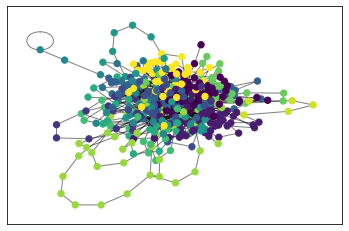

In [90]:
# compute the best partition
partition = community_louvain.best_partition(G)

# # draw the graph
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()